# 划分数据

由于要进行五重交叉验证，因此我们要将数据随机等分成五份，在partition文件夹下创建编号为0-4的五个文件夹，每个编号文件夹下都创建20个文件夹对应20个类，将全部文件依类别随机等分成五份移动到对应文件夹下。

In [1]:
import os, random, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pwd = os.getcwd()
data_path = pwd + '\\20_newsgroups'
count = 0
for file in os.listdir(data_path): # file 表示的是文件名
    count = count+1
clas = os.listdir(data_path)
print(count)
print(clas)

20
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


以下创建新的文件夹，并移动文件

执行过一次后就不要再执行以下两个代码块了

In [ ]:
os.mkdir(pwd+'\\partition')
for i in range(0,5):
    os.mkdir(pwd+'\\partition'+'\\'+str(i))
    for cla in clas:
        os.mkdir(pwd+'\\partition'+'\\'+str(i)+'\\'+cla)

In [10]:
for cla in clas:
    files = os.listdir(data_path+'\\'+cla)
    random.shuffle(files)
    p_list = [files[i::5] for i in range(5)]
    for j in range(0,5):
        for name in p_list[j]:
            shutil.move(data_path+'\\'+cla+'\\'+name, pwd+'\\partition\\'+str(j)+'\\'+cla+'\\')

# 参数估计

先选取序号4为验证集，序号0-3为训练集。

## 计算类别的先验概率
统计每一类的文件数目放入N_c中，形成array，然后加总得到文件总数目记为N，用N_c array与N作除法，得到类别的先验概率再取对数。

In [3]:
validation = 4
N = 0
N_c =[]

for cla in clas:
    filenumber = 0
    for i in range(0,5):
        if i == validation:
            continue
        files = os.listdir(pwd+'\\'+'partition'+'\\'+str(i)+'\\'+cla)
        filenumber=filenumber+len(files)
    N_c.append(filenumber)
    N = N + filenumber
N_p = np.array(N_c)/N
N_p = np.log(N_p)
print(N_c)
print(N_p)
print(N)

[800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 798, 800, 800, 800, 800]
[-2.99560727 -2.99560727 -2.99560727 -2.99560727 -2.99560727 -2.99560727
 -2.99560727 -2.99560727 -2.99560727 -2.99560727 -2.99560727 -2.99560727
 -2.99560727 -2.99560727 -2.99560727 -2.9981104  -2.99560727 -2.99560727
 -2.99560727 -2.99560727]
15998


## 得到类别嵌套列表与文件嵌套列表
读取文件，分词，一个文件中的所有词形成一个列表，用append方法将此列表添加进total_df，用extend方法将此列表添加到该类的词项列表l_1中，读取过该类的全部文件后，将得到的该类的词项列表l_1添加到total列表中（用append方法）。最终得到一个类别嵌套列表total，total列表共有20个子列表分别对应20个类，每个子列表中是该类的所有单词（未去重）。最终也得到一个文件嵌套列表total_df，total_df列表中每一个子列表代表一个文件，内含该文件的全部分词。

In [4]:
sum = 0
total_df=[]
total=[]
for cla in clas:
    l_1=[]
    for i in range(0,5):
        if i==validation:
            continue
        files = os.listdir(pwd+'\\'+'partition'+'\\'+str(i)+'\\'+cla) # 文件名
        for file in files:
            try:
                f = open(pwd+'\\'+'partition'+'\\'+str(i)+'\\'+cla+'\\'+file,"r",encoding='utf8') 
                line = f.read()
                l = line.split()
                total_df.append(l)
                l_1.extend(l)
            except:
                sum = sum+1
                continue
    print(cla)
    total.append(l_1)

alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey
sci.crypt
sci.electronics
sci.med
sci.space
soc.religion.christian
talk.politics.guns
talk.politics.mideast
talk.politics.misc
talk.religion.misc


由于windows编码问题，共无法读取63个文件

In [5]:
sum

63

## 特征选取（基于文档频率）

### 计算每个词的文档频率
遍历total_df，对于每个文件中的词，用set去重，保证重复的词只遍历一次，在字典中添加或更新。用其它方法效率很低。

In [6]:
df_dic =  {}
for file in total_df:
    for word in set(file):
        if word in df_dic:
            df_dic[word]+=1
        else:
            df_dic[word]=1

### 对频率小于某个阈值或大于某个阈值的词项删除
注意这里不能遍历字典的同时删除字典中的键值对，只有进行这样的遍历，才能同时对字典进行改动：'for key in list(df_dic.keys()):'

词表B的大小为当前df_dic的大小。


In [7]:
dele=[]
up = 800
down = 3
for key in list(df_dic.keys()):
    if df_dic[key]>up or df_dic[key]<down: # 选取阈值
        dele.append(key)
        df_dic.pop(key)

In [8]:
len(dele)

315247

可以看出共删除了315247个词项。

In [9]:
b = len(df_dic)
b

90266

可以看出此时词表中剩下的词项个数为90266个。

## 计算词项出现的条件概率
对于每一类的所有词（这个词必须在现在的词表中）统计词在该类中出现的词频，将每个类的这个信息存入字典(词项：词频)，20个类对应20个字典，再将这些字典存入列表。再作计算：
`dic_1[key] = np.log((dic_1[key]+k)/(a+b*k))`

a表示词表中的词出现在该类中的词频之和（对于类中的每个词（允许词重复），如果该词出现在了df_dic词表中，a加1），b表示词表数目B。
这里的k即为lambda，表示平滑选取的超参数。


In [10]:
k  = 1
pdic=[]
for cla in total:
    dic_1={}
    a=0
    for word in cla:
        if word in df_dic:
            a+=1
            if word in dic_1:
                dic_1[word] += 1
            else:
                dic_1[word] =1
    print(a)
    for key in dic_1:
        dic_1[key] = np.log((dic_1[key]+k)/(a+b*k))
    pdic.append(dic_1)

110649
87362
70254
69909
63586
93943
62138
77757
74131
84562
110014
124162
74627
106528
109587
129021
126613
188563
146996
122820


# 测试

对测试集按类循环，测试每一类的所有文件，对每一文件进行词频统计，存入字典（词项：词频），一共20个类，要根据先前存的参数计算该文件属于某一类的概率值。分类器将该文件划分到概率值最高的那一类。如果这一文件的某个词不存在于存储的参数中，使用平滑方法来避免0概率问题。还应注意如果该文件中某词多次出现，那么应该多次相加。预测出该文件属于某一类后在结果向量中其对应位置加1，将20个类的结果向量堆叠，最终得到混淆矩阵。

In [11]:
sum=0
for cla in clas:
    coun = np.zeros(20)
    files=os.listdir(pwd+'\\'+'partition'+'\\'+str(validation)+'\\'+cla)
    for file in files:
        di = {}
        try:
            f = open(pwd+'\\'+'partition'+'\\'+str(validation)+'\\'+cla +'\\'+file,"r",encoding='utf8')
            line = f.read()
        except:
            sum=sum+1
            continue
        l = line.split()
        for word in l:
            if word in di:
                di[word]+=1
            else:
                di[word]=1
        reli = []
        for i in range(0,20):
            noex = np.log(k/(len(total[i])+b*k))
            re = N_p[i]
            for key in di:
                if key in pdic[i]:
                    tem = di[key]*pdic[i][key]
                else:
                    tem = di[key]*noex
                re = re+tem
            reli.append(re)
        ind = reli.index(max(reli))
        coun[ind] = coun[ind]+1
    print(coun)
    if cla == 'alt.atheism':
        m = coun
    else:
        m = np.vstack((m,coun))

[160.   0.   0.   0.   1.   0.   9.   0.   1.   0.   0.   0.   1.   0.
   0.   0.   0.   0.   0.  26.]
[  0. 169.   3.   3.   5.   6.  12.   0.   0.   0.   0.   0.   2.   0.
   0.   0.   0.   0.   0.   0.]
[  0.   4. 161.  19.   3.   0.  13.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.]
[  0.   1.   4. 175.   8.   0.  12.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.]
[  0.   1.   2.   0. 185.   0.   6.   0.   0.   0.   0.   0.   3.   0.
   0.   0.   0.   0.   0.   0.]
[  0.   5.   1.   2.   4. 178.  10.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.]
[  0.   0.   1.   1.   3.   0. 187.   4.   0.   0.   0.   0.   4.   0.
   0.   0.   0.   0.   0.   0.]
[  0.   0.   0.   0.   0.   0.  12. 178.   4.   0.   0.   0.   6.   0.
   0.   0.   0.   0.   0.   0.]
[  0.   0.   0.   0.   0.   0.   6.   1. 193.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.]
[  0.   0.   0.   0.   1.   0.   6.   0.   1. 191.   0.   0.   0.   0.
  

由于windows的编码问题，无法读取而跳过的文件

In [12]:
sum

10

根据混淆矩阵计算每一类的precision（对角元素除以其所在列）、recall（对角元素除以其所在行）以及F值，最后使用宏平均，再计算准确率（accuracy）（对角元素加和除以所有元素之和）。

In [13]:
P_list = []
R_list = []
F_list = []
acc = 0
for i in range(0,20):
    p = m[i][i]/np.sum(m.T[i])
    # print(p)
    r = m[i][i]/np.sum(m[i])
    acc = acc+m[i][i]
    f = 2*p*r/(p+r)
    P_list.append(p)
    R_list.append(r)
    F_list.append(f)
p = np.mean(P_list)
r = np.mean(R_list)
f = np.mean(F_list)
a = acc/m.sum()
print(p)
print(r)
print(f)
print(a)

0.8713541939352843
0.8501138712843301
0.8534920611464459
0.8500877412885435


# 封装函数

为便于循环，将以上代码封装入函数

validation：选编号几作为验证集；
k：选几作为平滑参数，一般选1，即为拉普拉斯平滑；
up：当文档频率大于几时，将其从词表中删除；
down：当文档频率小于几时，将其从词表中删除。

In [3]:
def cal(validation,k,up,down):
    N = 0
    N_c =[]
    for cla in clas:
        filenumber = 0
        for i in range(0,5):
            if i == validation:
                continue
            files = os.listdir(pwd+'\\'+'partition'+'\\'+str(i)+'\\'+cla)
            filenumber=filenumber+len(files)
        N_c.append(filenumber)
        N = N + filenumber
    N_p = np.array(N_c)/N
    N_p = np.log(N_p)
    
    total_df=[]
    total=[]
    for cla in clas:
        l_1=[]
        for i in range(0,5):
            if i==validation:
                continue
            files = os.listdir(pwd+'\\'+'partition'+'\\'+str(i)+'\\'+cla) # 文件名
            for file in files:
                try:
                    f = open(pwd+'\\'+'partition'+'\\'+str(i)+'\\'+cla+'\\'+file,"r",encoding='utf8') 
                    line = f.read()
                    l = line.split()
                    total_df.append(l)
                    l_1.extend(l)
                except:
                    continue
        # print(cla)
        total.append(l_1)
    df_dic =  {}
    
    for file in total_df:
        for word in set(file):
            if word in df_dic:
                df_dic[word]+=1
            else:
                df_dic[word]=1
    
    dele=[]
    for key in list(df_dic.keys()):
        if df_dic[key]>up or df_dic[key]<down: # 选取阈值
            dele.append(key)
            df_dic.pop(key)
    b = len(df_dic)
    
    pdic=[]
    for cla in total:
        dic_1={}
        a=0
        for word in cla:
            if word in df_dic:
                a+=1
                if word in dic_1:
                    dic_1[word] += 1
                else:
                    dic_1[word] =1
        for key in dic_1:
            dic_1[key] = np.log((dic_1[key]+k)/(a+b*k))
        pdic.append(dic_1)
        
        
    for cla in clas:
        coun = np.zeros(20)
        files=os.listdir(pwd+'\\'+'partition'+'\\'+str(validation)+'\\'+cla)
        for file in files:
            di = {}
            try:
                f = open(pwd+'\\'+'partition'+'\\'+str(validation)+'\\'+cla +'\\'+file,"r",encoding='utf8')
                line = f.read()
            except:
                continue
            l = line.split()
            for word in l:
                if word in di:
                    di[word]+=1
                else:
                    di[word]=1
            reli = []
            for i in range(0,20):
                noex = np.log(k/(len(total[i])+b*k))
                re = N_p[i]
                for key in di:
                    if key in pdic[i]:
                        tem = di[key]*pdic[i][key]
                    else:
                        tem = di[key]*noex
                    re = re+tem
                reli.append(re)
            ind = reli.index(max(reli))
            coun[ind] = coun[ind]+1
        if cla == 'alt.atheism':
            m = coun
        else:
            m = np.vstack((m,coun))
            
    P_list = []
    R_list = []
    F_list = []
    acc = 0
    for i in range(0,20):
        p = m[i][i]/np.sum(m.T[i])
    # print(p)
        r = m[i][i]/np.sum(m[i])
        acc = acc+m[i][i]
        f = 2*p*r/(p+r)
        P_list.append(p)
        R_list.append(r)
        F_list.append(f)
    p = np.mean(P_list)
    r = np.mean(R_list)
    f = np.mean(F_list)
    a = acc/m.sum()
#     print(p)
#     print(r)
#     print(f)
#     print(a)
    return p,r,f,a

进行一次尝试

In [4]:
cal(4,1,800,3)

(0.8713541939352843,
 0.8501138712843301,
 0.8534920611464459,
 0.8500877412885435)

为五重交叉验证封装函数，执行该函数就做了五重交叉验证。

In [5]:
def val(k,up,down):
    pl = []
    rl = []
    fl = []
    al = []
    for v in range(0,5):
        p,r,f,a = cal(v,k,up,down)
        pl.append(p)
        rl.append(r)
        fl.append(f)
        al.append(a)
    return [np.mean(pl),np.mean(rl),np.mean(fl),np.mean(al)]

# 交叉验证

## 选取down

首先固定k=1与up=800，调整down=0,1,2,3

In [20]:
re = []
re.append(val(1,800,0))
re.append(val(1,800,1))
re.append(val(1,800,2))
re.append(val(1,800,3))

In [21]:
re

[[0.8995437614007644,
  0.9002728125379111,
  0.899179076957221,
  0.9002214250253735],
 [0.8995437614007644,
  0.9002728125379111,
  0.899179076957221,
  0.9002214250253735],
 [0.8822574676202348,
  0.8761641429272314,
  0.8755251798783844,
  0.8760784080556017],
 [0.867477772242989,
  0.8440398728585328,
  0.8465682916694748,
  0.8439054641159037]]

In [22]:
ret = np.array(re).T

In [23]:
ret

array([[0.89954376, 0.89954376, 0.88225747, 0.86747777],
       [0.90027281, 0.90027281, 0.87616414, 0.84403987],
       [0.89917908, 0.89917908, 0.87552518, 0.84656829],
       [0.90022143, 0.90022143, 0.87607841, 0.84390546]])

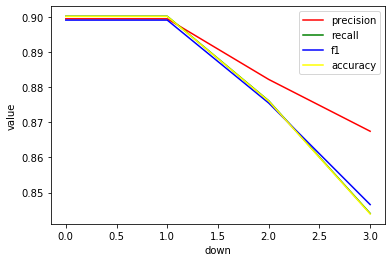

In [26]:
li = [0,1,2,3]
plt.plot(li,ret[0], color = 'red', label = 'precision')
plt.plot(li,ret[1], color = 'green', label = 'recall')
plt.plot(li,ret[2], color = 'blue',label = 'f1')
plt.plot(li,ret[3],color = 'yellow',label='accuracy')
plt.xlabel('down')
plt.ylabel('value')
plt.legend(['precision', 'recall', 'f1','accuracy'])
plt.show()

选取down=0

## 选取up

其次固定k=1与down=0 ,调整up=400,600,800,1000

In [27]:
re = []
re.append(val(1,400,0))
re.append(val(1,600,0))
re.append(val(1,800,0))
re.append(val(1,1000,0))
ret = np.array(re).T
ret

array([[0.87648033, 0.88687665, 0.89954376, 0.90023192],
       [0.87430264, 0.88673835, 0.90027281, 0.90107103],
       [0.87393779, 0.88594529, 0.89917908, 0.89993004],
       [0.87427182, 0.8867197 , 0.90022143, 0.90102449]])

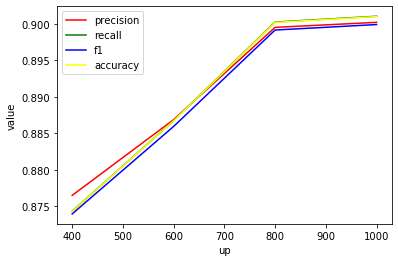

In [28]:
li = [400,600,800,1000]
plt.plot(li,ret[0], color = 'red', label = 'precision')
plt.plot(li,ret[1], color = 'green', label = 'recall')
plt.plot(li,ret[2], color = 'blue',label = 'f1')
plt.plot(li,ret[3],color = 'yellow',label='accuracy')
plt.xlabel('up')
plt.ylabel('value')
plt.legend(['precision', 'recall', 'f1','accuracy'])
plt.show()

似乎仍然有增长的趋势，故继续调整up=1200,1500

In [29]:
re = []
re.append(val(1,1200,0))
re.append(val(1,1500,0))
ret = np.array(re).T
ret

array([[0.8989063 , 0.89855453],
       [0.8995657 , 0.89925912],
       [0.89845178, 0.89815188],
       [0.89951887, 0.8992182 ]])

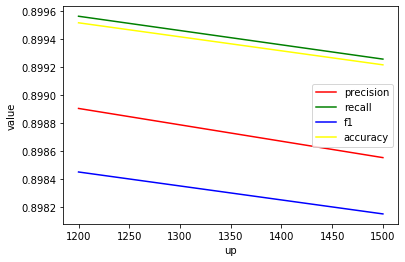

In [31]:
li = [1200,1500]
plt.plot(li,ret[0], color = 'red', label = 'precision')
plt.plot(li,ret[1], color = 'green', label = 'recall')
plt.plot(li,ret[2], color = 'blue',label = 'f1')
plt.plot(li,ret[3],color = 'yellow',label='accuracy')
plt.xlabel('up')
plt.ylabel('value')
plt.legend(['precision', 'recall', 'f1','accuracy'])
plt.show()

选取up=1000

## 选取k(平滑值)

最后固定up=1000 与down= 0，调整k=0.5，1，1.5，2

In [6]:
re = []
re.append(val(0.5,1000,0))
re.append(val(1,1000,0))
re.append(val(1.5,1000,0))
re.append(val(2,1000,0))
ret = np.array(re).T
ret

array([[0.89600694, 0.90023192, 0.89808941, 0.89667636],
       [0.89576278, 0.90107103, 0.89905534, 0.89749267],
       [0.89486035, 0.89993004, 0.89779604, 0.89623853],
       [0.89570464, 0.90102449, 0.89901707, 0.89746051]])

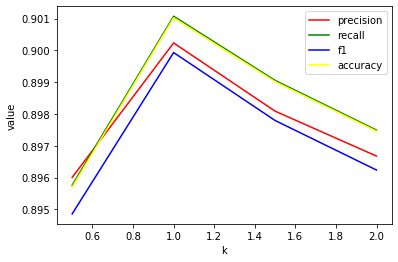

In [9]:
li = [0.5,1,1.5,2]
plt.plot(li,ret[0], color = 'red', label = 'precision')
plt.plot(li,ret[1], color = 'green', label = 'recall')
plt.plot(li,ret[2], color = 'blue',label = 'f1')
plt.plot(li,ret[3],color = 'yellow',label='accuracy')
plt.xlabel('k')
plt.ylabel('value')
plt.legend(['precision', 'recall', 'f1','accuracy'])
plt.show()

选取k=1,还是拉普拉斯平滑更好。

综上，应该选择k=1,up=1000,down=0，也就是将文档频率超过1000的词项删除，并且选择拉普拉斯平滑。

In [10]:
rep = val(1,1000,0)
print(rep)

[0.9002319230403846, 0.9010710258265767, 0.8999300400797802, 0.9010244869792097]


五重交叉验证结果：

|  指标   | 数值  |
|  ----  | ----  |
| precision  | 0.9002319230403846 |
| recall  | 0.9010710258265767 |
| f1  | 0.8999300400797802 |
| accuracy  | 0.9010244869792097 |
